# Glassdoor Salary Analysis
This notebook loads, cleans, and analyzes salary data from Glassdoor job listings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
# Load dataset
df = pd.read_csv('glassdoor_jobs.csv')

In [17]:
df.head(10)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,Min Salary (K),Max Salary (K),Avg Salary (K),Job Category,Sector Grouped,Industry Grouped
0,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe,"San Jose, CA",10000+ Employees,1982.0,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD),83.0,153.0,118.0,Data Scientist,Information Technology,Computer Hardware Development
1,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM,"Atlanta, GA",10000+ Employees,1911.0,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),71.0,133.0,102.0,Data Scientist,Information Technology,Information Technology Support Services
2,Data Scientist 2,Employer Provided Salary:$94K - $183K,The Microsoft 365 team is looking for a Data S...,4.3,Microsoft,"Redmond, WA",10000+ Employees,1975.0,Company - Public,Computer Hardware Development,Information Technology,$10+ billion (USD),94.0,183.0,138.5,Data Scientist,Information Technology,Computer Hardware Development
3,Entry Level Data Scientist 2023/2024,$48K - $78K (Glassdoor est.),"You may not realize it, but you’ve likely used...",3.9,CPChem,"The Woodlands, TX",1001 to 5000 Employees,2000.0,Company - Private,Chemical Manufacturing,Manufacturing,$10+ billion (USD),48.0,78.0,63.0,Data Scientist,Manufacturing,Other
4,Senior Data Scientist,Employer Provided Salary:$141K - $254K,POSITION: Senior Data Scientist\n\nJOB Locatio...,3.6,AT&T,"Dallas, TX",10000+ Employees,1876.0,Company - Public,Telecommunications Services,Telecommunications,$10+ billion (USD),141.0,254.0,197.5,Data Scientist,Other,Other
6,Data Scientist,$102K - $138K (Glassdoor est.),Company Description\n\nVisa is a world leader ...,4.1,Visa,"Washington, DC",10000+ Employees,1958.0,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),102.0,138.0,120.0,Data Scientist,Information Technology,Information Technology Support Services
7,Data Scientist- CalAIM,Employer Provided Salary:$51.00 - $68.72 Per Hour,Salary: $51.00 - $68.72 Per Hour\nCommunity Pr...,3.3,Heluna Health,"Los Angeles, CA",1001 to 5000 Employees,1968.0,Nonprofit Organization,Civic & Social Services,Nonprofit & NGO,$25 to $100 million (USD),51.0,0.0,25.5,Data Scientist,Other,Other
8,Data Scientist,$88K - $133K (Glassdoor est.),"Spalding Consulting, Inc. is seeking a Data Sc...",4.0,"Spalding Consulting, Inc.","Havelock, NC",201 to 500 Employees,2001.0,Company - Private,Aerospace & Defense,Aerospace & Defense,$25 to $100 million (USD),88.0,133.0,110.5,Data Scientist,Aerospace & Defense,Aerospace & Defense
9,Data Scientist,Employer Provided Salary:$122K - $175K,Lawrence Berkeley National Laboratory has mult...,4.1,Lawrence Berkeley National Laboratory,"San Francisco, CA",1001 to 5000 Employees,1931.0,Government,Research & Development,Management & Consulting,$500 million to $1 billion (USD),122.0,175.0,148.5,Data Scientist,Management & Consulting,Research & Development
10,Junior Data Scientist,Employer Provided Salary:$70K - $105K,Company Description\n\nRead this first: If you...,3.9,Publicis Media,"New York, NY",10000+ Employees,1926.0,Company - Public,Advertising & Public Relations,Media & Communication,$5 to $10 billion (USD),70.0,105.0,87.5,Data Scientist,Media & Communication,Other


In [3]:
# Clean specific columns
df = df.copy()
string_columns = ['Salary Estimate', 'Industry']
numeric_columns = ['Rating', 'Founded']

In [4]:
for col in string_columns:
    df[col] = df[col].replace('-1', np.nan)

In [5]:
for col in numeric_columns:
    df[col] = df[col].replace(-1, np.nan)

In [6]:
df['Company Name'] = df['Company Name'].str.extract(r'^(.*?)(?:\n|$)')[0].str.strip()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
# Parse salary range into min, max, and avg
def parse_salary(s):
    s = re.sub(r'Employer Provided Salary:|Glassdoor est\.|Per Hour|Employer Provided Salary:', '', s)
    s = s.replace('$', '').replace('K', '').strip()
    match = re.findall(r'(\d+)', s)
    if len(match) >= 2:
        min_sal = int(match[0])
        max_sal = int(match[1])
        avg_sal = (min_sal + max_sal) / 2
        return pd.Series([min_sal, max_sal, avg_sal])
    return pd.Series([np.nan, np.nan, np.nan])

In [8]:
df[['Min Salary (K)', 'Max Salary (K)', 'Avg Salary (K)']] = df['Salary Estimate'].apply(parse_salary)
df.dropna(subset=['Avg Salary (K)'], inplace=True)

In [9]:
# Categorize job titles
def categorize_job_title(title):
    title = title.lower()
    if 'data scientist' in title:
        return 'Data Scientist'
    elif 'data engineer' in title:
        return 'Data Engineer'
    elif 'analyst' in title:
        return 'Data Analyst'
    elif 'machine learning' in title:
        return 'ML Engineer'
    elif 'research' in title:
        return 'Researcher'
    elif 'manager' in title:
        return 'Manager'
    else:
        return 'Other'

In [10]:
df['Job Category'] = df['Job Title'].apply(categorize_job_title)

In [11]:
# Simplify sector and industry
top_sectors = df['Sector'].value_counts().nlargest(8).index
top_industries = df['Industry'].value_counts().nlargest(10).index

In [12]:
df['Sector Grouped'] = df['Sector'].apply(lambda x: x if x in top_sectors else 'Other')
df['Industry Grouped'] = df['Industry'].apply(lambda x: x if x in top_industries else 'Other')

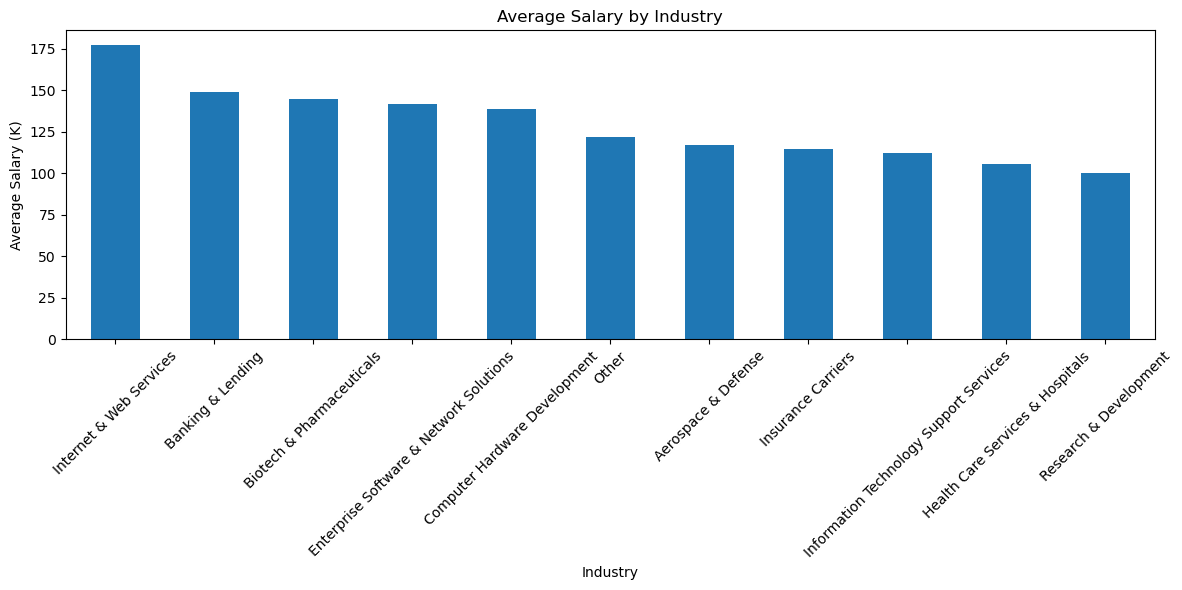

In [13]:
# Plot: Average Salary by Industry
plt.figure(figsize=(12, 6))
df.groupby('Industry Grouped')['Avg Salary (K)'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Average Salary by Industry')
plt.ylabel('Average Salary (K)')
plt.xlabel('Industry')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

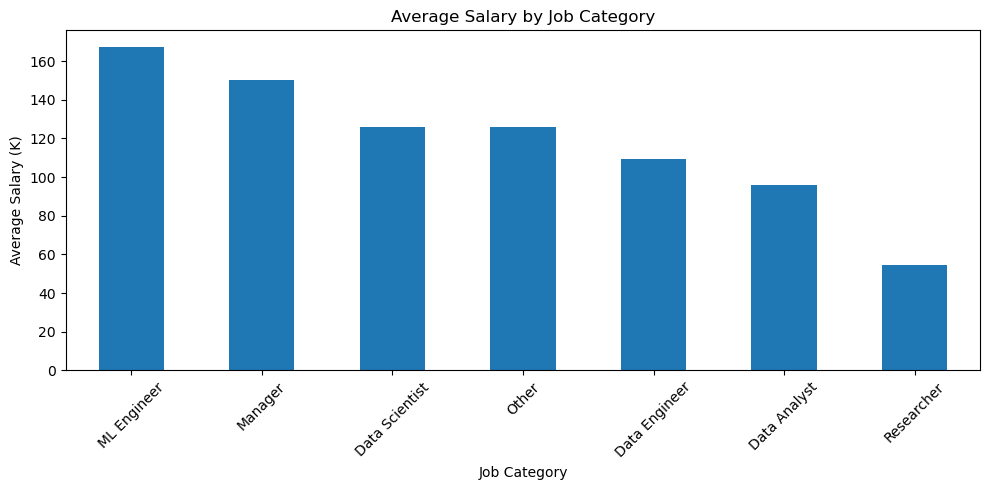

In [14]:
# Plot: Average Salary by Job Category
plt.figure(figsize=(10, 5))
df.groupby('Job Category')['Avg Salary (K)'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Average Salary by Job Category')
plt.ylabel('Average Salary (K)')
plt.xlabel('Job Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()